In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
import pickle

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from scipy import stats
from tqdm import tqdm

from procyon.data.data_utils import DATA_DIR
from procyon.data.inference_utils import (
    create_input_retrieval,
    get_proteins_from_embedding,
    UNIPROT_IDS,
)
from procyon.evaluate.framework.utils import move_inputs_to_device
from procyon.model.model_unified import UnifiedProCyon

# Protein Retrieval using as ground truth sets of genes identified through different sources - provided by OpenTargets dataset

# Load pre-trained model

In [3]:
# Replace with the path where you downloaded a pre-trained ProCyon model (e.g. ProCyon-Full)
checkpoint_path = "~/storage/Lab/PLM/huggingface_repos/ProCyon-Full"
CKPT_NAME = os.path.expanduser(checkpoint_path)

In [4]:
data_args = torch.load(os.path.join(CKPT_NAME, "data_args.pt"))
train_args = torch.load(os.path.join(CKPT_NAME, "training_args.pt"))

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, _ = UnifiedProCyon.from_pretrained(checkpoint_dir=CKPT_NAME)
model.bfloat16() # Quantize the model to a smaller precision
model.eval()
model.to(device)

updating model args DATA_DIR from /n/holystore01/LABS/mzitnik_lab/Lab/PLM -> /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/huggingface_repos/ProCyon-Instruct
updating stale DATA_DIR for model arg: go_embeddings_path
updating stale DATA_DIR for model arg: pfam_embeddings_path
updating stale DATA_DIR for model arg: drugbank_embeddings_path
updating stale DATA_DIR for model arg: reactome_embeddings_path
updating stale DATA_DIR for model arg: omim_embeddings_path
updating stale DATA_DIR for model arg: ec_embeddings_path
updating stale DATA_DIR for model arg: protein_seq_embeddings_path
updating stale DATA_DIR for model arg: protein_struct_embeddings_path
updating stale DATA_DIR for model arg: protein_embeddings_idmap_path
updating stale DATA_DIR for model arg: drug_struct_embeddings_path
updating stale DATA_DIR for model arg: domain_embeddings_path
updating stale DATA_DIR for model arg: domain_embeddings_idmap_path
updating stale DATA_DIR for model arg: mouse_ortholog_embeddings_path
updating stal

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565
Using sep_token, but it is not set yet.
Using pad_token, but it is not set yet.


Processing zero checkpoint '/n/home08/rcalef/storage/Lab/PLM/huggingface_repos/ProCyon-Split/global_step4497'
Detected checkpoint of type zero stage ZeroStageEnum.gradients, world_size: 16
Parsing checkpoint created by deepspeed==0.12.4
Reconstructed fp32 state dict with 322 params 6746619393 elements


UnifiedProCyon(
  (text_encoder): LlamaPostTokenization(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32007, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
              (act_fn): SiLUActivation()
            )
      

In [7]:
# Load saved embeddings for this model
all_protein_embeddings, all_protein_ids = torch.load(os.path.join(CKPT_NAME, "protein_target_embeddings.pkl"))
all_protein_embeddings = all_protein_embeddings.float()
print(all_protein_embeddings.shape)

torch.Size([18174, 2560])


# Retrieve omim descriptions for diseases of interest and GT from OpenTargets

In [8]:
data_path = os.path.join(
    DATA_DIR,
    "experimental_data",
    "protein_retrieval_multiple_sources",
)

descr = pd.read_csv(os.path.join(
    data_path,
    "omim_descriptions.csv",
))

with open(os.path.join(
    data_path,
    "gt_dict_thresh_multiple_types_flex_thresholds.pkl",
), 'rb') as f:
    gt_dict = pickle.load(f)

# Protein retrieval using OMIM descriptions as inpout and OpenTargets gene - disease associations as GT

Note that the following cell can take ~1 hour to run due to the large number of model queries. For this reason, we've made the cached scores availabie within ProCyon-Instruct, but feel free to set `regenerate_scores` to True if you'd like to rerun from scratch.

In [ ]:
regenerate_scores = True

ran = 0
if regenerate_scores:
    types = list(gt_dict["OpenTargets"].keys())

    scores_external = defaultdict(dict)

    for i, efo_subset in enumerate(tqdm(descr.efo)):
        # Skip EFO IDs that don't have any disease associated with them across any type
        found_types = []
        for t in types:
            if efo_subset in gt_dict["OpenTargets"][t] and \
            len(gt_dict["OpenTargets"][t][efo_subset]) > 0 and \
            UNIPROT_IDS.name.isin(gt_dict["OpenTargets"][t][efo_subset]).sum() != 0:
                found_types.append(t)

        if len(found_types) == 0:
            continue
        ran += 1
        if ran == 100:
            break

        input_desc = descr[descr.efo == efo_subset].omim_def_curated.item()
        input_simple = create_input_retrieval(
            input_description=input_desc,
            data_args=data_args,
            task_definition=None,
            instruction_source_dataset="disgenet",
            instruction_source_relation="all",
            aaseq_type="protein",
            icl_example_number=1,
        )
        input_simple = move_inputs_to_device(input_simple, device=device)

        with torch.no_grad():
            model_out = model(
                inputs=input_simple,
                retrieval=True,
                aaseq_type="protein",
            )
        df = get_proteins_from_embedding(
            protein_embeds=all_protein_embeddings,
            model_out=model_out,
            top_k=None,
        )

        for t in found_types:
            scores_external[t][efo_subset] = np.median(
                stats.percentileofscore(
                    df["sim_score"],
                    df["sim_score"].loc[
                        (df["name"].isin(gt_dict["OpenTargets"][t][efo_subset]))
                    ],
                )
            )

    df_external = pd.DataFrame.from_dict(scores_external)
    (
        df_external
        .rename_axis(index="efo")
        .reset_index()
        .to_csv(os.path.join(
            data_path,
            "validation_gt_different_sources.csv",
        ), index=False)
    )

/tmp/ipykernel_1285270/3179572652.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  catplot = sns.swarmplot(
/n/home08/rcalef/sandbox/repos/ProCyon/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 36.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/home08/rcalef/sandbox/repos/ProCyon/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 12.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_1285270/3179572652.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = catplot.set_xticklabels(
/n/home08/rcalef/sandbox/repos/ProCyon/

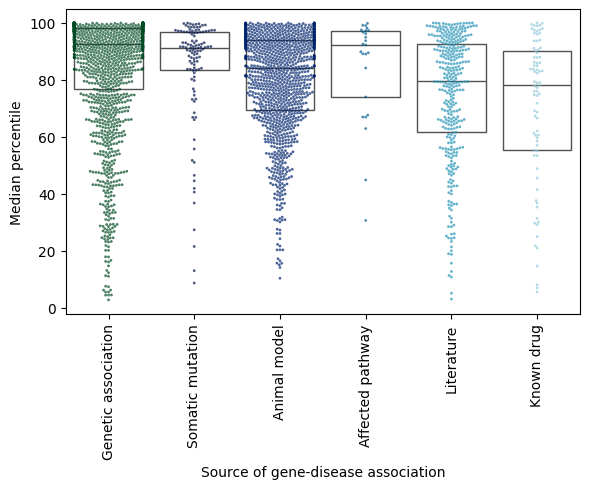

In [9]:
df = pd.read_csv(
    os.path.join(
        data_path,
        "validation_gt_different_sources.csv",
    )
)

df = (
    pd.melt(df, id_vars="efo", var_name="type")
    .loc[lambda x: ~x.value.isna()]
    .assign(
        type=lambda x: x.type.map({
                "animal_model": "Animal model",
                "genetic_association": "Genetic association",
                "somatic_mutation": "Somatic mutation",
                "affected_pathway": "Affected pathway",
                "literature": "Literature",
                "known_drug": "Known drug",
        })
    )
)

plt.figure(figsize=(6, 5))
catplot = sns.swarmplot(
    df,
    x="type",
    y="value",
    palette="ocean",
    order=[
        "Genetic association",
        "Somatic mutation",
        "Animal model",
        "Affected pathway",
        "Literature",
        "Known drug",
    ],
    size=2,
    alpha=0.7,
)
_ = catplot.set_xticklabels(
    labels=[
        "Genetic association",
        "Somatic mutation",
        "Animal model",
        "Affected pathway",
        "Literature",
        "Known drug",
    ],
    rotation=90,
)
catplot = sns.boxplot(
    x="type",
    y="value",
    data=df,
    showcaps=False,
    boxprops={"facecolor": "None"},
    showfliers=False,
    whiskerprops={"linewidth": 0},
)
plt.ylabel("Median percentile")
plt.xlabel("Source of gene-disease association")
plt.tight_layout()
#plt.savefig("external.png", dpi=300, bbox_inches="tight")